# Tutorial 2: Filtering and Pre-Processing

This notebook shows how to pre-process and filter trajectory dataframes using `nomad`. The `nomad` library currently provides functions for coordinate-system projection, and spatial, temporal, and quantity filtering.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches
from pyproj import Transformer

import nomad.io.base as loader
import nomad.filters as filters
from nomad.filters import to_projection, filter_users
from nomad.constants import DEFAULT_SCHEMA
import nomad.city_gen as cg

### Load Data

For the following examples, we load test data from `nomad`.

In [31]:
traj = loader.from_file('../nomad/data/gc_sample.csv', format='csv')

# create tz_offset column
traj['tz_offset'] = -18000

# create string datetime column
traj['local_datetime'] = loader.naive_datetime_from_unix_and_offset(
    traj['timestamp'], traj['tz_offset'])

# define schema/column names
traj_cols = DEFAULT_SCHEMA
traj_cols['user_id'] = 'uid'
traj_cols['datetime'] = 'local_datetime'

traj.head(10)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime
0,wizardly_joliot,1704119340,38.321711,-36.667334,-18000,2024-01-01 09:29:00
1,wizardly_joliot,1704119700,38.321676,-36.667365,-18000,2024-01-01 09:35:00
2,wizardly_joliot,1704155880,38.320959,-36.666748,-18000,2024-01-01 19:38:00
3,wizardly_joliot,1704156000,38.320936,-36.666739,-18000,2024-01-01 19:40:00
4,wizardly_joliot,1704156840,38.320924,-36.666747,-18000,2024-01-01 19:54:00
5,wizardly_joliot,1704157860,38.320994,-36.666773,-18000,2024-01-01 20:11:00
6,wizardly_joliot,1704157920,38.320964,-36.666763,-18000,2024-01-01 20:12:00
7,wizardly_joliot,1704158820,38.320921,-36.666750,-18000,2024-01-01 20:27:00
8,wizardly_joliot,1704161280,38.320971,-36.666809,-18000,2024-01-01 21:08:00
9,wizardly_joliot,1704183120,38.321758,-36.666434,-18000,2024-01-02 03:12:00


### Project between coordinate systems

Many geospatial datasets come in spherical coordiantes latitude/longitude (EPSG:4326). However, spatial analyses---like joins of points in polygons, computing buffers, or clustering pings---might benefit from computing euclidean distances. Thus projected planar coordinates (like EPSG:3857) are commonly used. Nomad's `to_projection` method creates new columns `x` and `y` with projected coordinates in any coordinate reference system (CRS) recognized by PyProj. 


In [33]:
# Project to EPSG:3857 (Web Mercator)
projected_x, projected_y = to_projection(traj=traj,
                                         input_crs="EPSG:4326",
                                         output_crs="EPSG:3857",
                                         longitude="longitude",
                                         latitude="latitude")

traj['x'] = projected_x
traj['y'] = projected_y

traj.head(10)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,-18000,2024-01-01 09:29:00,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,-18000,2024-01-01 09:35:00,-4.081792e+06,4.624968e+06
2,wizardly_joliot,1704155880,38.320959,-36.666748,-18000,2024-01-01 19:38:00,-4.081724e+06,4.624866e+06
3,wizardly_joliot,1704156000,38.320936,-36.666739,-18000,2024-01-01 19:40:00,-4.081723e+06,4.624863e+06
4,wizardly_joliot,1704156840,38.320924,-36.666747,-18000,2024-01-01 19:54:00,-4.081724e+06,4.624861e+06
5,wizardly_joliot,1704157860,38.320994,-36.666773,-18000,2024-01-01 20:11:00,-4.081727e+06,4.624871e+06
6,wizardly_joliot,1704157920,38.320964,-36.666763,-18000,2024-01-01 20:12:00,-4.081725e+06,4.624867e+06
7,wizardly_joliot,1704158820,38.320921,-36.666750,-18000,2024-01-01 20:27:00,-4.081724e+06,4.624861e+06
8,wizardly_joliot,1704161280,38.320971,-36.666809,-18000,2024-01-01 21:08:00,-4.081731e+06,4.624868e+06
9,wizardly_joliot,1704183120,38.321758,-36.666434,-18000,2024-01-02 03:12:00,-4.081689e+06,4.624980e+06


The following code visualizes the trajectory. We transform the coordinates in the sample data back to the Garden City coordinates (in a 22x22 box) so that we can visualize the city buildings alongside the blocks. The red box depicts the area we will filter to.

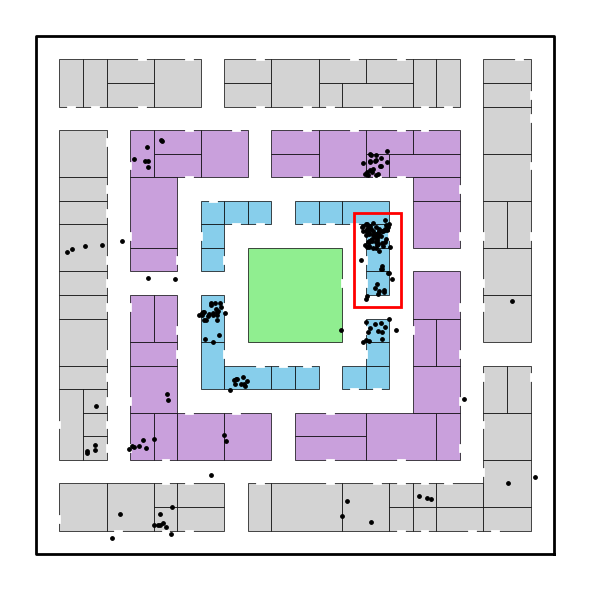

In [34]:
plot_df = traj[traj['uid'] == "agitated_chebyshev"].copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['latitude'].values, plot_df['longitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

polygon_coords = [
    (13.5, 14.5), 
    (13.5, 10.5), 
    (15.5, 10.5), 
    (15.5, 14.5)
]
polygon = Polygon(polygon_coords)

polygon_patch = patches.Polygon(polygon.exterior.coords, closed=True, edgecolor='red', facecolor='none', linewidth=2, label="Polygon")
plt.gca().add_patch(polygon_patch)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Filter to a specified geometry

We often need to filter down the dataset to the most relevant records. This involves filtering along three key dimensions:
- Spatial Filtering: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia). Use the `polygon` argument.
- Temporal Filtering: Restrict data to a time window of interest (e.g., January). Use the `start_time` and `end_time` arguments. If 
- Quantity-Based Filtering: Keep only users with sufficient activity as measured by a minimum number of pings. Use the `min_active_days` and `min_pings_per_day` arguments.

If the aforementioned arguments are not specified, the default arguments ensure that the respective filtering is not performed. E.g., `polygon` defaults to `None`, and so no spatial filtering is performed.

These filtering functions help clean and prepare your dataset for downstream analysis by focusing only on users who are present, active, and engaged in the geographic area and timeframe you care about.

In [35]:
polygon_coords = [
    (-4.081775e+06, 4.62490e+06), 
    (-4.081775e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62490e+06)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)
uq0 = traj['uid'].unique()

filtered_traj = filter_users(traj=traj, 
                             start_time=pd.Timestamp("2024-01-01 00:00:00", tz='America/New_York'),
                             end_time=pd.Timestamp("2024-01-31 23:59:00", tz='America/New_York'),
                             polygon=polygon,
                             min_active_days=2,
                             min_pings_per_day=10,
                             user_id='uid',
                             x='x',
                             y='y')

n1 = len(filtered_traj)
uq1 = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")


Number of pings before filtering: 25835
Number of unique users before filtering: 100
Number of pings after filtering: 11083
Number of unique users after filtering: 16


### Visualize completeness and filter by completeness metric

In [ ]:
# Construct daily Q matrix
Q = filters._generate_Q_matrix(traj, traj_cols)

/var/folders/9v/zcb15thj2wb7b8tn11chj_cw0000gn/T/ipykernel_11140/2649643016.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Q_window = df_Dates.groupby(['date']).apply(lambda x : _compute_mean_q(Q,x.values[0,0], SW_width_days))


In [ ]:
# Perform sliding window Q computation
SW_width_days = 3  # width of the sliding window in days
SW_dates = Q.index[:-SW_width_days]  # dates involved in the sliding window computation
df_Dates= pd.DataFrame(SW_dates)

Q_window = df_Dates.groupby('date', group_keys=False).apply(
    lambda x: filters._compute_mean_q(Q, x.values[0, 0], SW_width_days),
    include_groups=False
)

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/var/folders/9v/zcb15thj2wb7b8tn11chj_cw0000gn/T/ipykernel_11140/3244590154.py:11: SyntaxWarning: invalid escape sequence '\e'
  'title': '$\epsilon \quad (\%)$',
/var/folders/9v/zcb15thj2wb7b8tn11chj_cw0000gn/T/ipykernel_11140/3244590154.py:21: SyntaxWarning: invalid escape sequence '\e'
  'title': f'Daily time-series of complete users \n over {SW_width_days} days sliding window with $\epsilon$ tolerance',


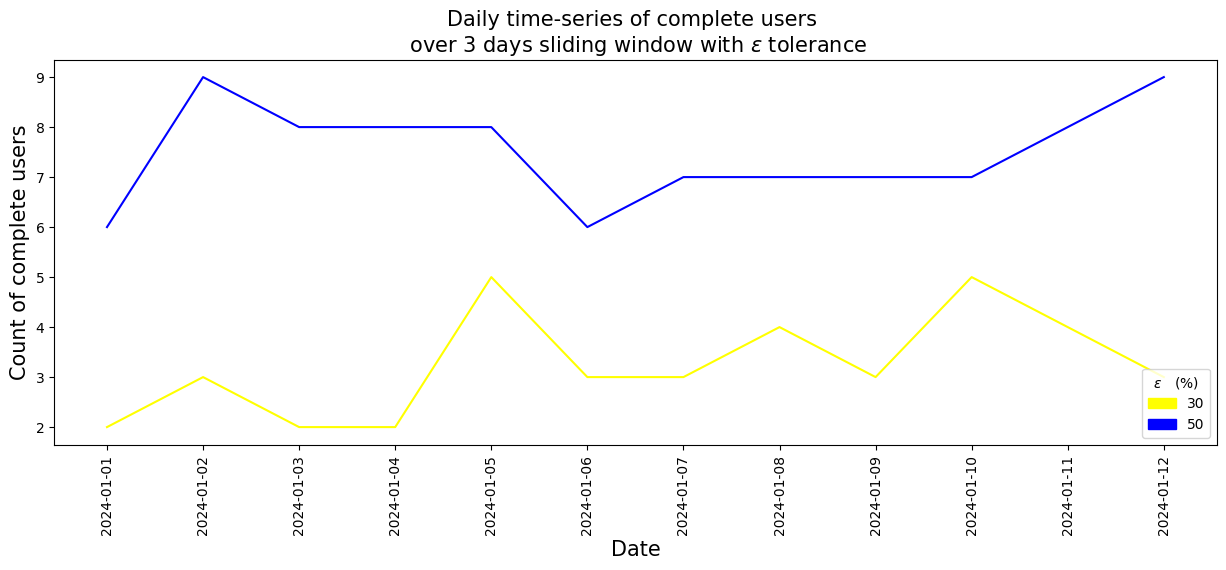

In [ ]:
#Visualize daily complete users for different values of epsilon

LIST_eps = [0.3,0.5]
Colors_eps = ['yellow', 'blue']
X = range(len(SW_dates))

DICT_legend= {'classes': [int(e*100) for e in LIST_eps], 
              'colors': Colors_eps, 
              'loc': 'lower right', 
              'fontsize':10,
              'title': '$\epsilon \quad (\%)$', 
              'title_fontsize':10}

DICT_ticks = {'t': X, 
              'tl': SW_dates, 
              'rot': 90, 
              'size':10}

DICT_label_titles = {'xlabel': 'Date', 
                     'ylabel': 'Count of complete users', 
                     'title': f'Daily time-series of complete users \n over {SW_width_days} days sliding window with $\epsilon$ tolerance', 
                     'label_size': 15, 
                     'title_size': 15}

fig, ax = plt.subplots(figsize = (15,5))

for eps,color in zip(LIST_eps, Colors_eps):
    #Counts of complete users for each date - based on eps tolerance
    I_complete_eps = (Q_window > (1-eps)).sum(axis=1)
    ax.plot(X, I_complete_eps.values, color = color, label = eps)

filters._ax_visual_legend(ax, DICT_legend)
filters._ax_visual_ticklabel(ax, DICT_ticks, axis = 'x')
filters._ax_visual_labeltitles(ax, DICT_label_titles)